<a href="https://colab.research.google.com/github/luistunag/sentinel2-convlstm-prediction/blob/main/sentinel2_spatiotemporal_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 25.5 MB/s eta 0:00:00


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00


Import libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import keras_tuner as kt

In [ ]:
# Mount Google Drive to access project files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the folder in Google Drive
base_path = '/content/drive/My Drive/data_xela'

# List files in the folder to verify
print(os.listdir(base_path))

['Moisture_index_xela', 'NDWI_xela', 'False_color_xela', 'SWIR_xela', 'NDVI_xela', 'Scene_classification_map_xela']


Load and normalize data

In [ ]:
# Functions to load and normalize images
def load_and_downsample_images_rgb(folder_path, scale_factor=0.75):
    time_series_data = []
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith('.tiff'):
            file_path = os.path.join(folder_path, file_name)
            with rasterio.open(file_path) as src:
                data = src.read([1, 2, 3])  # Read bands 1, 2, 3 (RGB)
                data = np.transpose(data, (1, 2, 0))  # (height, width, channels)
                downsampled_data = cv2.resize(data, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
                time_series_data.append(downsampled_data)
    return np.array(time_series_data) / 255.0  # Normalize to range [0, 1]

def load_and_normalize_scene_classification(folder_path, scale_factor=0.75):
    time_series_data = []
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith('.tiff'):
            file_path = os.path.join(folder_path, file_name)
            with rasterio.open(file_path) as src:
                data = src.read(1)  # Read only the first band (categorical)
                downsampled_data = cv2.resize(data, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
                normalized_data = downsampled_data / np.max(downsampled_data)  # Normalize
                time_series_data.append(np.expand_dims(normalized_data, axis=-1))  # Add as a single channel
    return np.array(time_series_data)

# Load and normalize data
ndvi_data_norm = load_and_downsample_images_rgb(os.path.join(base_path, 'NDVI_xela'), scale_factor=0.75)
ndwi_data_norm = load_and_downsample_images_rgb(os.path.join(base_path, 'NDWI_xela'), scale_factor=0.75)
swir_data_norm = load_and_downsample_images_rgb(os.path.join(base_path, 'SWIR_xela'), scale_factor=0.75)
false_color_data_norm = load_and_downsample_images_rgb(os.path.join(base_path, 'False_color_xela'), scale_factor=0.75)
moisture_index_data_norm = load_and_downsample_images_rgb(os.path.join(base_path, 'Moisture_index_xela'), scale_factor=0.75)
scene_class_data_norm = load_and_normalize_scene_classification(os.path.join(base_path, 'Scene_classification_map_xela'), scale_factor=0.75)

print("Shape of NDVI data (downsampled):", ndvi_data_norm.shape)
print("Shape of NDWI data (downsampled):", ndwi_data_norm.shape)

Shape of NDVI data (downsampled): (32, 330, 319, 3)
Shape of NDWI_xela (downsampled): (32, 330, 319, 3)


Exploratory analysis and visualization

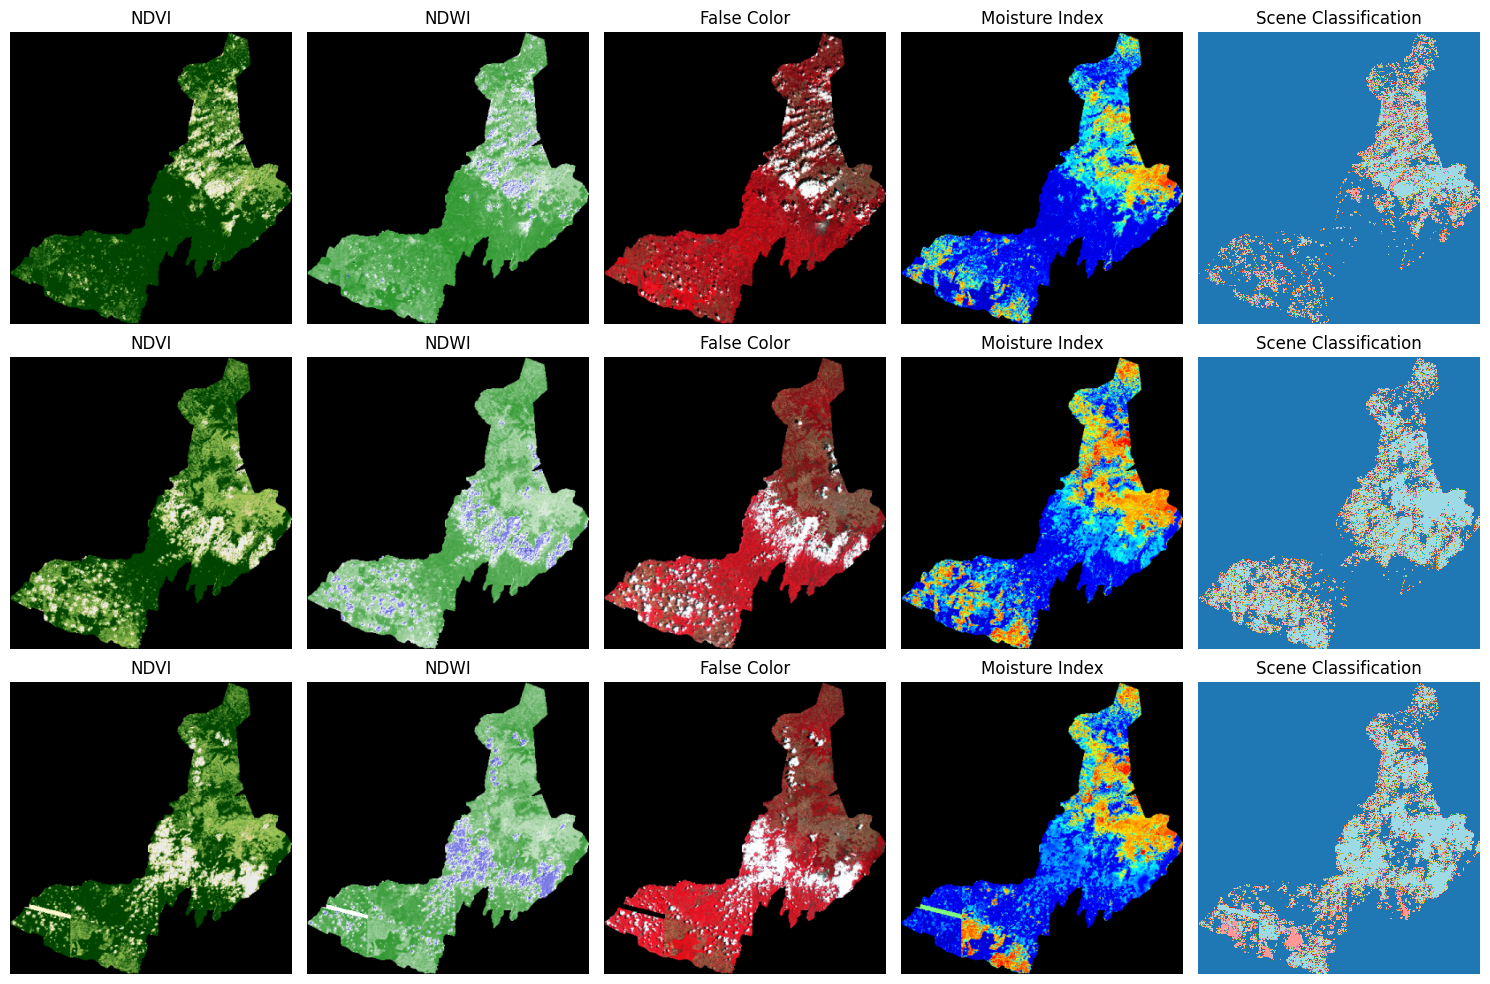

In [ ]:
# Function to normalize data for visualization
def normalize_for_display(data):
    data_min = np.min(data)
    data_max = np.max(data)
    if data_max - data_min == 0:
        return np.zeros_like(data)  # If the range is zero, return a black image
    return (data - data_min) / (data_max - data_min)

# Visualize some images from different layers
def visualize_data_samples(ndvi, ndwi, false_color, moisture_index, scene_class, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 5, i * 5 + 1)
        plt.imshow(normalize_for_display(ndvi[i]), cmap='YlGn')
        plt.title('NDVI')
        plt.axis('off')

        plt.subplot(num_samples, 5, i * 5 + 2)
        plt.imshow(normalize_for_display(ndwi[i]), cmap='Blues')
        plt.title('NDWI')
        plt.axis('off')

        plt.subplot(num_samples, 5, i * 5 + 3)
        # False color is already RGB, only normalize
        plt.imshow(normalize_for_display(false_color[i]))
        plt.title('False Color')
        plt.axis('off')

        plt.subplot(num_samples, 5, i * 5 + 4)
        plt.imshow(normalize_for_display(moisture_index[i]), cmap='viridis')
        plt.title('Moisture Index')
        plt.axis('off')

        plt.subplot(num_samples, 5, i * 5 + 5)
        plt.imshow(scene_class[i, :, :, 0], cmap='tab20')  # Show the scene classification layer
        plt.title('Scene Classification')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_data_samples(ndvi_data_norm, ndwi_data_norm, false_color_data_norm, moisture_index_data_norm, scene_class_data_norm)

Seasonal analysis

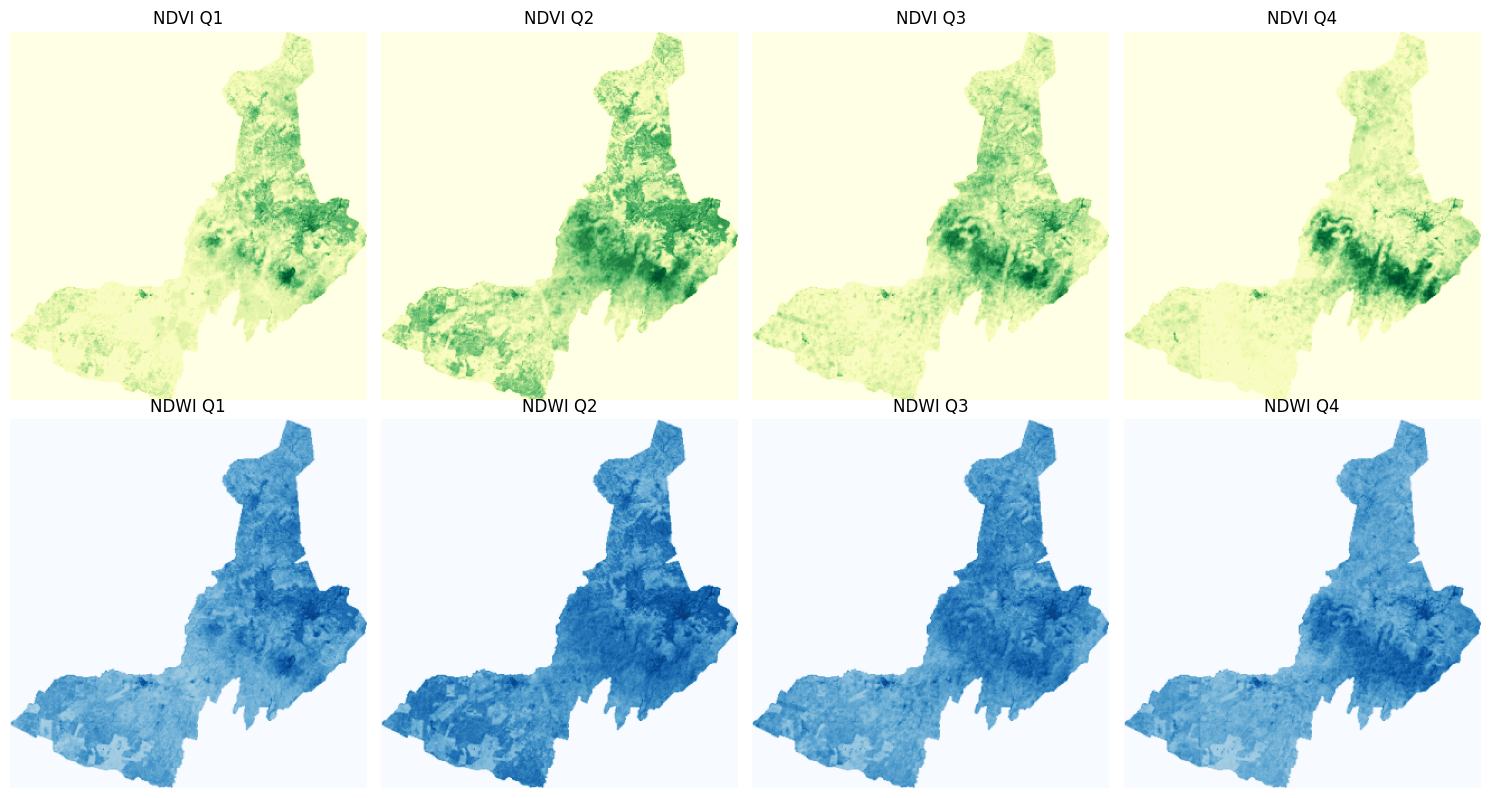

In [ ]:
# Calculate seasonal average values for NDVI and NDWI
num_years = ndvi_data_norm.shape[0] // 4
seasons = ['Q1', 'Q2', 'Q3', 'Q4']

# Initialize matrices to store seasonal averages
seasonal_ndvi_means = np.zeros((4, ndvi_data_norm.shape[1], ndvi_data_norm.shape[2]))
seasonal_ndwi_means = np.zeros((4, ndwi_data_norm.shape[1], ndwi_data_norm.shape[2]))

# Compute seasonal averages
for season_idx in range(4):  # There are 4 quarters
    seasonal_ndvi = [np.mean(ndvi_data_norm[i], axis=2) for i in range(season_idx, num_years * 4, 4)]  # Average across bands
    seasonal_ndwi = [np.mean(ndwi_data_norm[i], axis=2) for i in range(season_idx, num_years * 4, 4)]  # Average across bands

    seasonal_ndvi_means[season_idx] = np.mean(seasonal_ndvi, axis=0)
    seasonal_ndwi_means[season_idx] = np.mean(seasonal_ndwi, axis=0)

# Visualize seasonal changes for NDVI and NDWI
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(seasonal_ndvi_means[i], cmap='YlGn')
    plt.title(f'NDVI {seasons[i]}')
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.imshow(seasonal_ndwi_means[i], cmap='Blues')
    plt.title(f'NDWI {seasons[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Temporal trend analysis

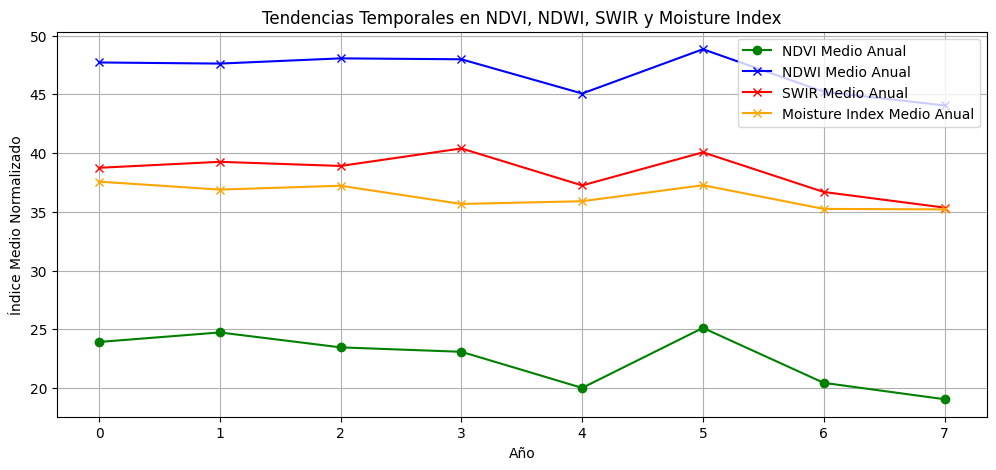

In [ ]:
# Calculate annual mean values for NDVI, NDWI, SWIR and Moisture Index
annual_ndvi_means = [np.mean(ndvi_data_norm[i*4:(i+1)*4], axis=(1, 2, 3)) for i in range(num_years)]
annual_ndwi_means = [np.mean(ndwi_data_norm[i*4:(i+1)*4], axis=(1, 2, 3)) for i in range(num_years)]
annual_swir_means = [np.mean(swir_data_norm[i*4:(i+1)*4], axis=(1, 2, 3)) for i in range(num_years)]
annual_moisture_index_means = [np.mean(moisture_index_data_norm[i*4:(i+1)*4], axis=(1, 2, 3)) for i in range(num_years)]

# Compute global annual means
annual_ndvi_means = np.mean(annual_ndvi_means, axis=1)
annual_ndwi_means = np.mean(annual_ndwi_means, axis=1)
annual_swir_means = np.mean(annual_swir_means, axis=1)
annual_moisture_index_means = np.mean(annual_moisture_index_means, axis=1)

# Visualize annual trends of NDVI, NDWI, SWIR and Moisture Index
years = range(num_years)
plt.figure(figsize=(12, 5))
plt.plot(years, annual_ndvi_means, label='Annual Mean NDVI', marker='o', color='green')
plt.plot(years, annual_ndwi_means, label='Annual Mean NDWI', marker='x', color='blue')
plt.plot(years, annual_swir_means, label='Annual Mean SWIR', marker='x', color='red')
plt.plot(years, annual_moisture_index_means, label='Annual Mean Moisture Index', marker='x', color='orange')
plt.xlabel('Year')
plt.ylabel('Normalized Mean Index')
plt.title('Temporal Trends in NDVI, NDWI, SWIR and Moisture Index')
plt.legend()
plt.grid(True)
plt.show()

Correlation analysis between indices

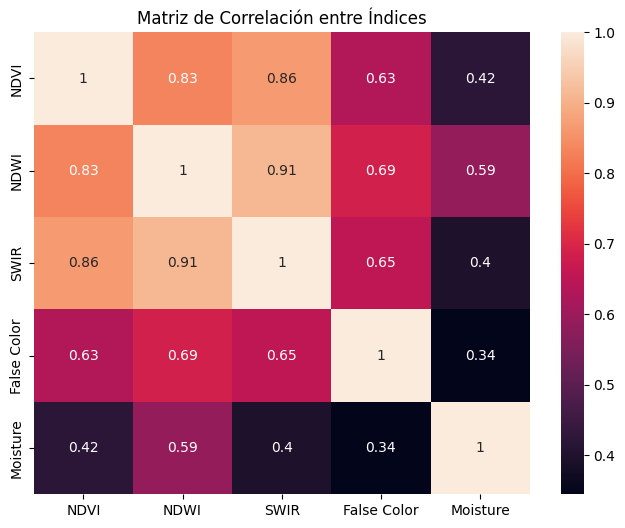

In [ ]:
# Flatten data for correlation analysis
ndvi_flat = ndvi_data_norm.flatten()
ndwi_flat = ndwi_data_norm.flatten()
swir_flat = swir_data_norm.flatten()
false_color_flat = false_color_data_norm.flatten()
moisture_index_flat = moisture_index_data_norm.flatten()

# Calculate correlation
correlations = np.corrcoef([ndvi_flat, ndwi_flat, swir_flat, false_color_flat, moisture_index_flat])

# Visualize the correlation matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True,
            xticklabels=['NDVI', 'NDWI', 'SWIR', 'False Color', 'Moisture'],
            yticklabels=['NDVI', 'NDWI', 'SWIR', 'False Color', 'Moisture'])
plt.title('Correlation Matrix between Indices')
plt.show()

Average spatial visualization

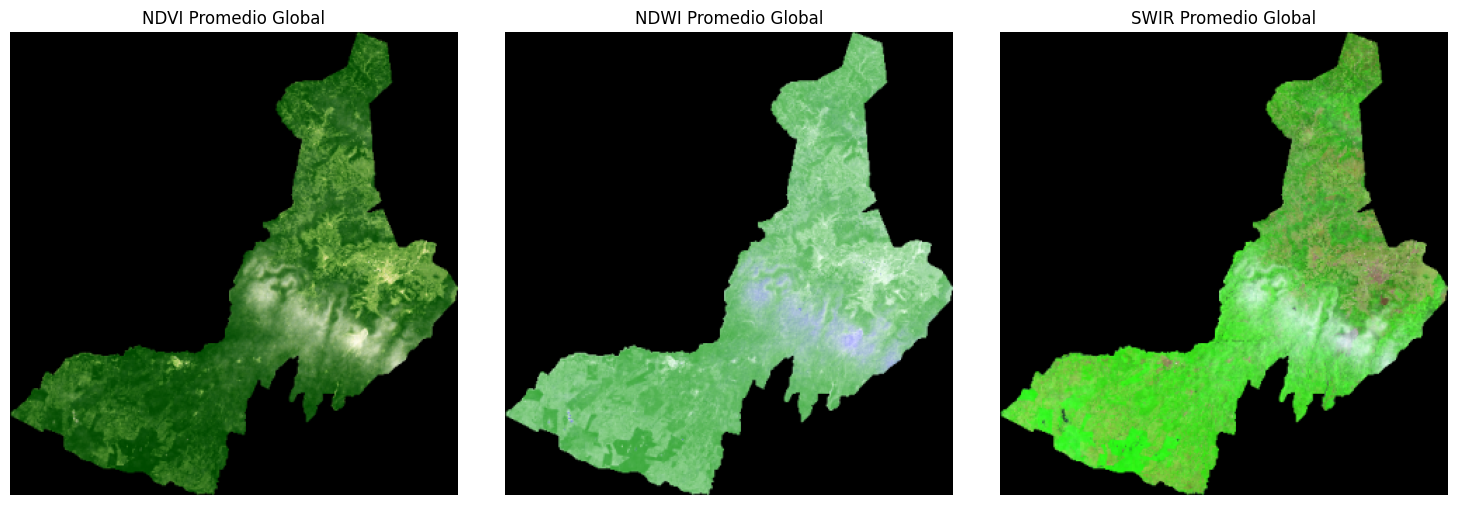

In [ ]:
# Calculate the global mean for the entire period
ndvi_global_mean = np.mean(ndvi_data_norm, axis=0)
ndwi_global_mean = np.mean(ndwi_data_norm, axis=0)
swir_global_mean = np.mean(swir_data_norm, axis=0)

# Normalize the averaged data to the range [0, 1]
ndvi_global_mean_normalized = (ndvi_global_mean - np.min(ndvi_global_mean)) / (np.max(ndvi_global_mean) - np.min(ndvi_global_mean))
ndwi_global_mean_normalized = (ndwi_global_mean - np.min(ndwi_global_mean)) / (np.max(ndwi_global_mean) - np.min(ndwi_global_mean))
swir_global_mean_normalized = (swir_global_mean - np.min(swir_global_mean)) / (np.max(swir_global_mean) - np.min(swir_global_mean))

# Visualize spatial averages
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(ndvi_global_mean_normalized, cmap='YlGn')
plt.title('Global Mean NDVI')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ndwi_global_mean_normalized, cmap='Blues')
plt.title('Global Mean NDWI')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(swir_global_mean_normalized, cmap='viridis')
plt.title('Global Mean SWIR')
plt.axis('off')

plt.tight_layout()
plt.show()

Predict full images

In [ ]:
# Combine all layers
combined_x = np.concatenate(
    [ndvi_data_norm, ndwi_data_norm, swir_data_norm, false_color_data_norm, moisture_index_data_norm, scene_class_data_norm],
    axis=-1
)

# Split data into train and test
x_train, x_test = train_test_split(combined_x, test_size=0.2, random_state=42)


# Define the improved ConvLSTM model to predict full images
model = Sequential()

sequence_length = 4  # 4 quarters (1 year)

# Combined loss function
def combined_loss(y_true, y_pred):
    mse = MeanSquaredError()(y_true, y_pred)
    huber = Huber()(y_true, y_pred)
    return mse + 0.5 * huber

# Model builder function with hyperparameters
def build_model(hp):
    model = Sequential()

    # Kernel sizes mapped as tuples
    kernel_sizes = [(3, 3), (5, 5)]

    # Hyperparameter choices
    filters_1 = hp.Choice('filters_1', values=[32, 64, 128, 256])
    kernel_index_1 = hp.Choice('kernel_size_1', values=[0, 1])  # 0 -> (3, 3), 1 -> (5, 5)
    kernel_size_1 = kernel_sizes[kernel_index_1]

    model.add(ConvLSTM2D(
        filters=filters_1,
        kernel_size=kernel_size_1,
        activation='tanh',
        input_shape=(sequence_length, x_train.shape[1], x_train.shape[2], x_train.shape[3]),
        padding='same',
        return_sequences=True,
        kernel_regularizer=l2(0.01)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_1', values=[0.1, 0.3, 0.5])))

    # Second ConvLSTM2D layer
    filters_2 = hp.Choice('filters_2', values=[32, 64, 128, 256])
    kernel_index_2 = hp.Choice('kernel_size_2', values=[0, 1])  # 0 -> (3, 3), 1 -> (5, 5)
    kernel_size_2 = kernel_sizes[kernel_index_2]

    model.add(ConvLSTM2D(
        filters=filters_2,
        kernel_size=kernel_size_2,
        activation='tanh',
        padding='same',
        return_sequences=True,
        kernel_regularizer=l2(0.01)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_2', values=[0.1, 0.3, 0.5])))

    # Third ConvLSTM2D layer
    filters_3 = hp.Choice('filters_3', values=[16, 32, 64, 128])
    kernel_index_3 = hp.Choice('kernel_size_3', values=[0, 1])  # 0 -> (3, 3), 1 -> (5, 5)
    kernel_size_3 = kernel_sizes[kernel_index_3]

    model.add(ConvLSTM2D(
        filters=filters_3,
        kernel_size=kernel_size_3,
        activation='tanh',
        padding='same',
        return_sequences=False,
        kernel_regularizer=l2(0.01)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_3', values=[0.1, 0.3, 0.5])))

    # Conv2D refinement layers
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))

    # Output layer
    model.add(Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='mean_squared_error'
    )

    return model

# Configure Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,            # number of configurations to try
    executions_per_trial=1,   # runs per configuration for stability
    directory='hyperparam_tuning',
    project_name='satellite_data_prediction'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Function to generate an image sequence

In [ ]:
batch_size = 1

# Define sequence generator for images
def sequence_generator_images(data, sequence_length, batch_size, target_channel=3):
    num_samples = data.shape[0] - sequence_length
    indices = np.arange(num_samples)

    while True:
        np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]

            batch_x = []
            batch_y = []
            for i in batch_indices:
                x_seq = data[i:i + sequence_length]  # (sequence_length, height, width, channels)
                batch_x.append(x_seq)
                # Use the full target channel image as label
                y_seq = data[i + sequence_length][:, :, target_channel]  # Use only the target channel
                batch_y.append(y_seq)

            batch_x = np.array(batch_x)  # Shape: (batch_size, sequence_length, height, width, channels)
            batch_y = np.array(batch_y)  # Shape: (batch_size, height, width)
            yield batch_x, batch_y

Function to visualize images by variable

In [ ]:
def visualize_predictions(model, x_test, target_channel, num_samples=2):
    # Ensure we do not exceed the batch size
    num_samples = min(num_samples, batch_size)

    # Get a batch of test data
    x_test_batch, y_test_batch = next(sequence_generator_images(
        x_test, sequence_length, batch_size, target_channel=target_channel
    ))

    # Make predictions
    predictions = model.predict(x_test_batch)

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Visualize the ground truth (target channel)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(normalize_for_display(y_test_batch[i]), cmap='YlGn')
        plt.title('Ground Truth')
        plt.axis('off')

        # Visualize the prediction
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(normalize_for_display(predictions[i].squeeze()), cmap='YlGn')
        plt.title('Prediction')
        plt.axis('off')

        # Visualize the difference (error)
        plt.subplot(num_samples, 3, i * 3 + 3)
        difference = np.abs(y_test_batch[i] - predictions[i].squeeze())
        plt.imshow(normalize_for_display(difference), cmap='hot')
        plt.title('Difference (Error)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Define callback EarlyStopping
stop_early = EarlyStopping(monitor='val_loss', patience=3)

Train the model

Trial 10 Complete [00h 01m 03s]
val_loss: 2042.9635009765625

Best val_loss So Far: 1586.7646484375
Total elapsed time: 00h 27m 07s
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 493ms/step - loss: 2320.5090 - val_loss: 3068.5977
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - loss: 1997.6086 - val_loss: 2853.9446
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - loss: 1519.8369 - val_loss: 2804.8953
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step - loss: 1431.5692 - val_loss: 2577.8596
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - loss: 1456.9557 - val_loss: 2436.5144
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step - loss: 1362.1230 - val_loss: 2376.4082
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - loss: 1521.8929 - val_loss: 2208.6780
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - loss: 1401.3268 - val_loss: 2454.9883
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - loss: 1358.5331 - val_loss: 1729.5693
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 

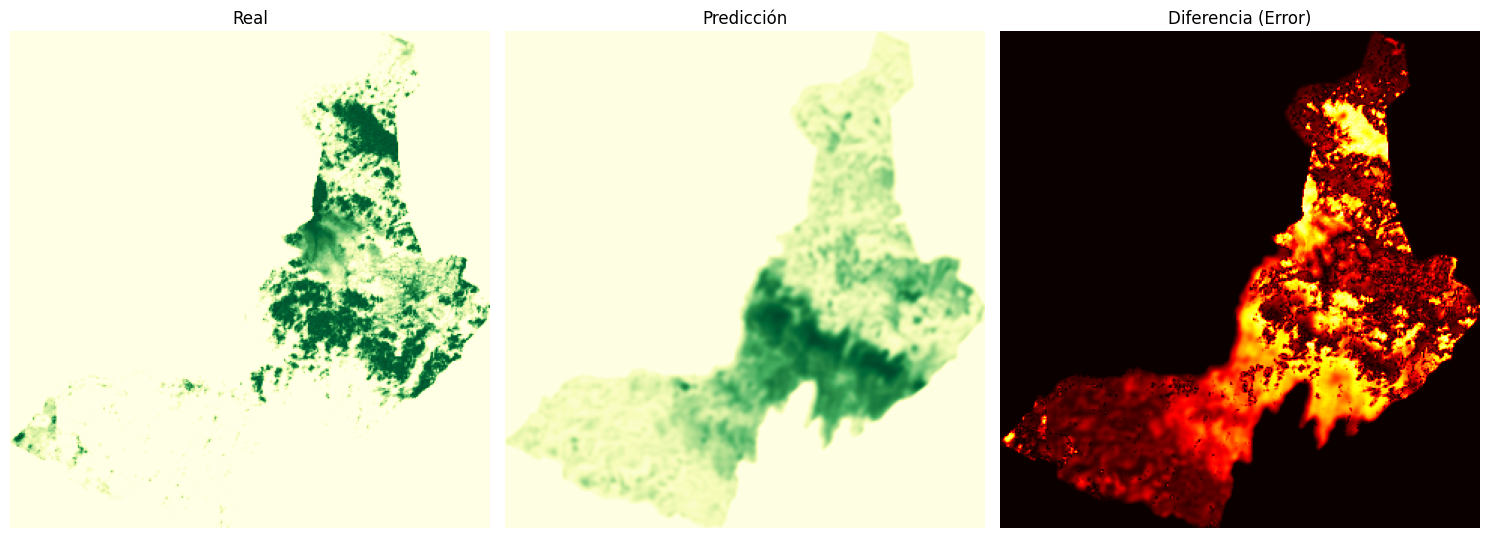

NDVI completado.

Procesando NDWI
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 514ms/step - loss: 4332.3096 - val_loss: 5310.6157
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - loss: 2165.6306 - val_loss: 3113.7012
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - loss: 729.0381 - val_loss: 2494.7251
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - loss: 637.9934 - val_loss: 2486.4209
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - loss: 577.5886 - val_loss: 2255.1506
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - loss: 583.1749 - val_loss: 1920.8774
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - loss: 587.9933 - val_loss: 1759.2328
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 561.6087 - val_loss: 1634.9625
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - loss: 566.9523 - val_loss: 1502.3540
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 558.0320 - val_loss: 1179.7928
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step

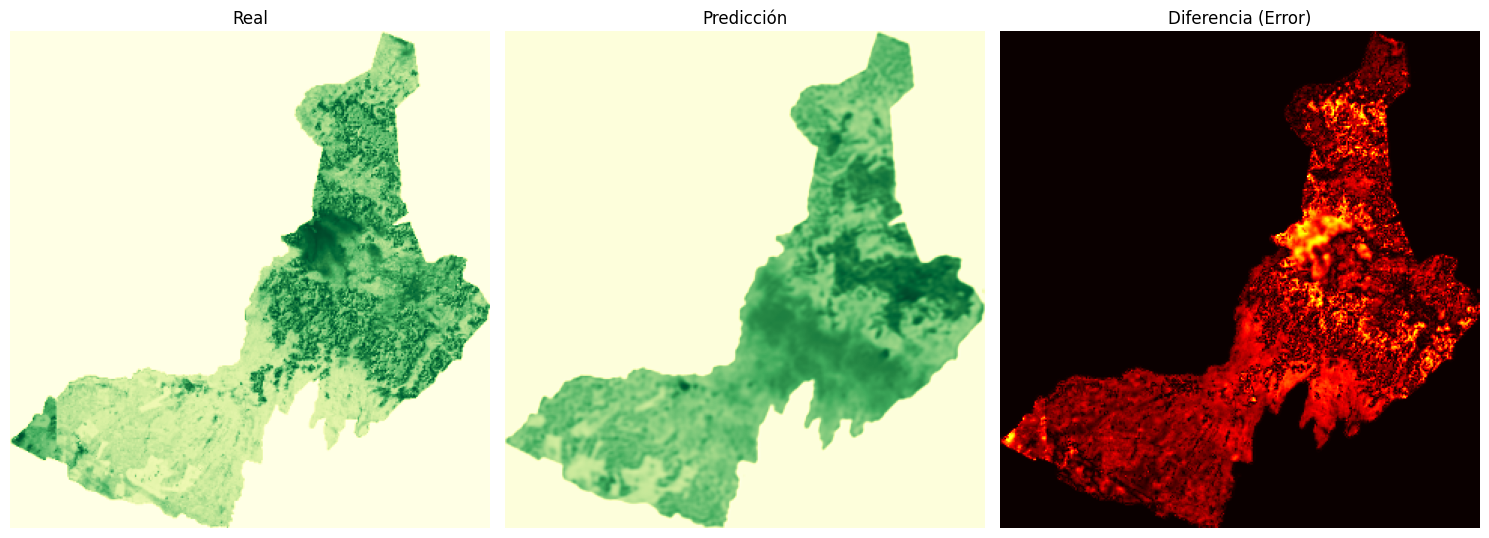

NDWI completado.

Procesando SWIR
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 495ms/step - loss: 3579.5588 - val_loss: 4062.0002
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - loss: 1814.6748 - val_loss: 3119.7488
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - loss: 896.1113 - val_loss: 2654.7205
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - loss: 994.9974 - val_loss: 2522.3232
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step - loss: 911.3076 - val_loss: 2296.3413
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - loss: 1108.1454 - val_loss: 2193.8469
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - loss: 883.0811 - val_loss: 1944.2939
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - loss: 897.2582 - val_loss: 1672.3478
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 1007.1364 - val_loss: 1736.9473
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - loss: 798.0147 - val_loss: 1547.6964
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/st

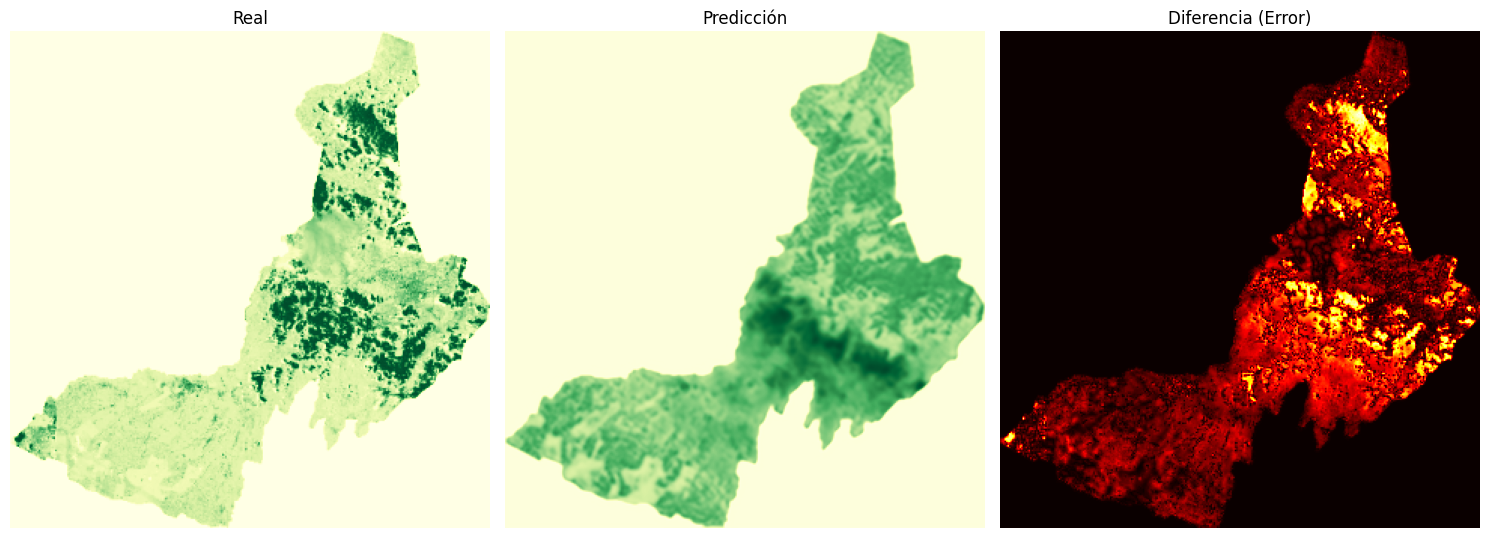

SWIR completado.

Procesando False Color
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - loss: 10995.0742 - val_loss: 10780.5000
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - loss: 8963.5537 - val_loss: 8248.8662
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - loss: 4874.8218 - val_loss: 4954.3281
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - loss: 1618.5062 - val_loss: 3143.8054
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - loss: 574.4540 - val_loss: 2593.8796
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - loss: 553.0768 - val_loss: 3077.5808
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - loss: 538.3268 - val_loss: 2323.9968
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 553.9077 - val_loss: 1871.5664
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - loss: 549.0995 - val_loss: 1895.6903
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 548.4424 - val_loss: 1379.3705
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s

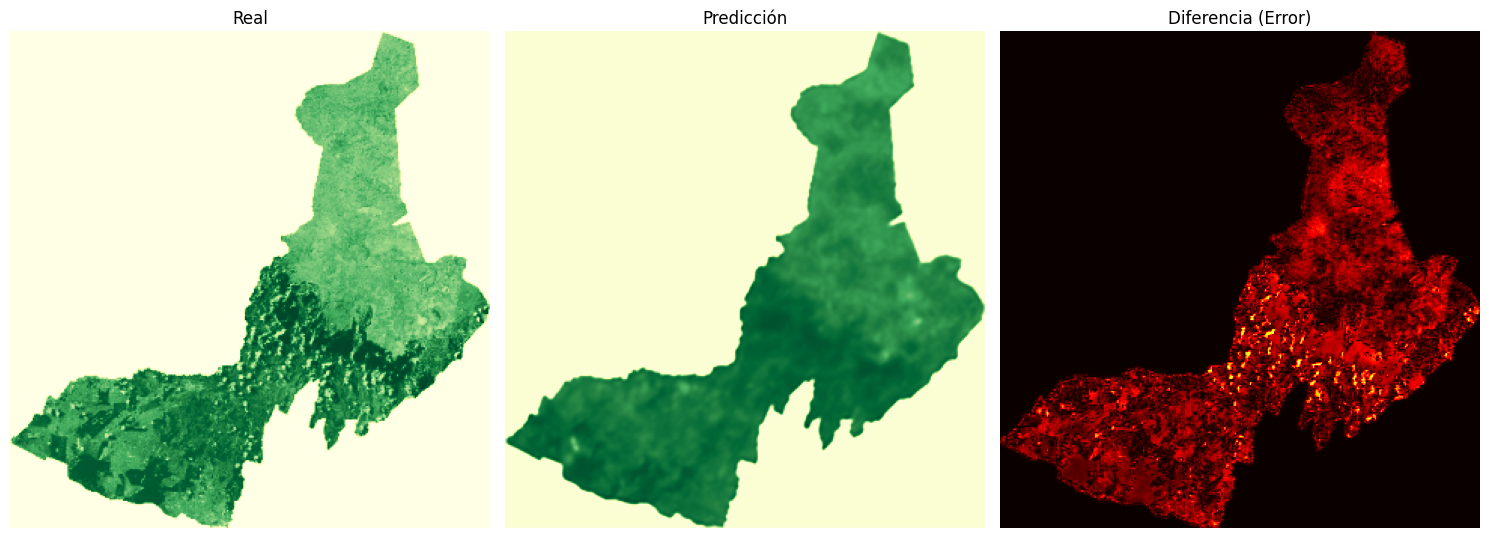

False Color completado.

Procesando Moisture Index
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - loss: 1810.3983 - val_loss: 2731.1482
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - loss: 1566.2192 - val_loss: 2667.0950
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - loss: 1437.7598 - val_loss: 2653.3306
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - loss: 1625.7133 - val_loss: 2450.3306
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - loss: 1343.7864 - val_loss: 2513.1174
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - loss: 1169.8970 - val_loss: 2375.8542
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - loss: 1101.3374 - val_loss: 2171.6052
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - loss: 1105.6844 - val_loss: 2198.7727
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 1249.3719 - val_loss: 2257.8967
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - loss: 1093.4641 - val_loss: 2083.4036
Epoch 11/50
21/21 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


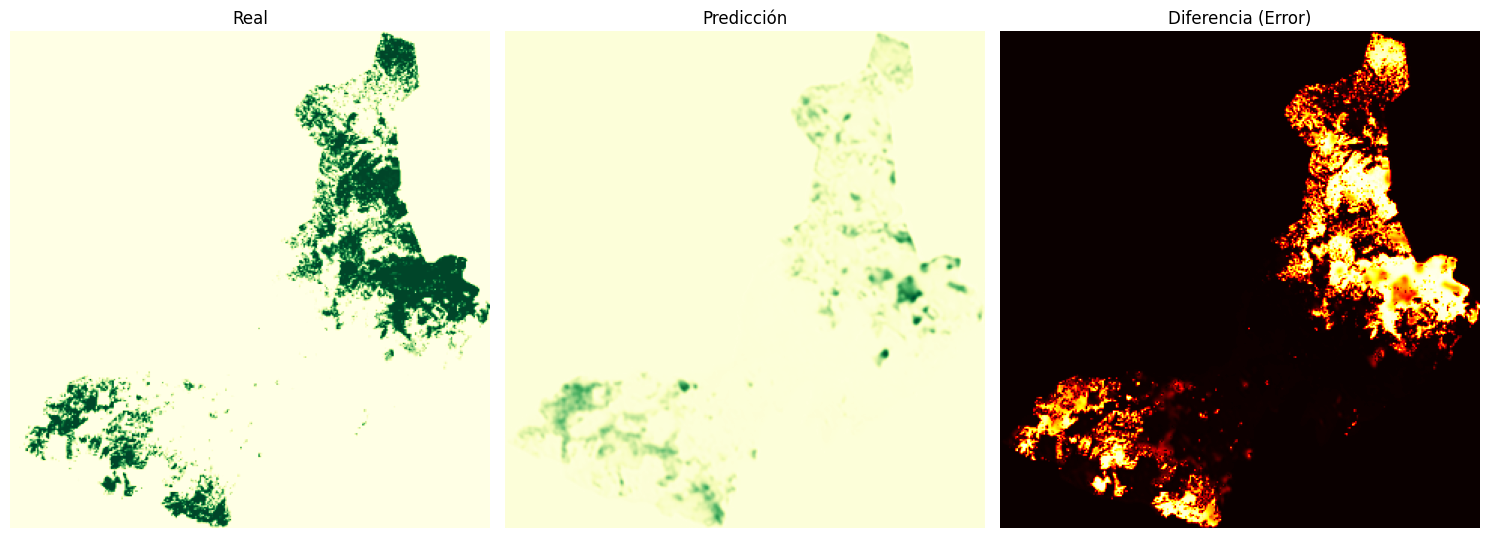

Moisture Index completado.

Procesando Scene Classification Map
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - loss: 2.5248 - val_loss: 1.9780
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - loss: 2.0375 - val_loss: 1.8313
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step - loss: 1.8287 - val_loss: 1.6785
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - loss: 1.6624 - val_loss: 1.5334
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step - loss: 1.4998 - val_loss: 1.3953
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step - loss: 1.3689 - val_loss: 1.2773
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - loss: 1.2408 - val_loss: 1.1541
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - loss: 1.1326 - val_loss: 1.0584
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 1.0268 - val_loss: 0.9652
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - loss: 0.9424 - val_loss: 0.8843
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - loss: 0.8637 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


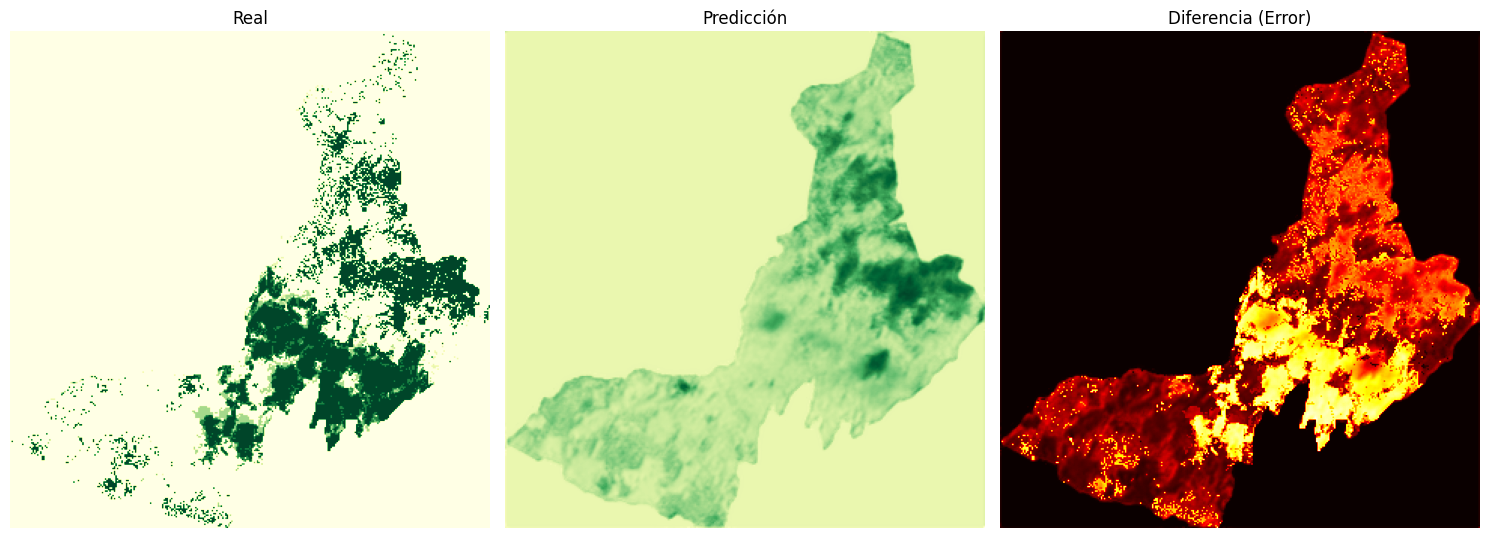

Scene Classification Map completado.



In [ ]:
# List of variables and their target channels
variables = [
    {'name': 'NDVI', 'channel': 0},
    {'name': 'NDWI', 'channel': 3},
    {'name': 'SWIR', 'channel': 6},
    {'name': 'False Color', 'channel': 9},
    {'name': 'Moisture Index', 'channel': 12},
    {'name': 'Scene Classification Map', 'channel': 15}
]

# Train and visualize predictions for each variable
for variable in variables:
    print(f"Processing {variable['name']}")

    # Compute steps per epoch for the generator
    steps_per_epoch = (x_train.shape[0] - sequence_length) // batch_size
    validation_steps = (x_test.shape[0] - sequence_length) // batch_size

    # Create generators for training and validation
    train_gen = sequence_generator_images(
        x_train, sequence_length, batch_size, target_channel=variable['channel']
    )
    val_gen = sequence_generator_images(
        x_test, sequence_length, batch_size, target_channel=variable['channel']
    )

    # Run hyperparameter search
    tuner.search(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=20,
        callbacks=[stop_early]
    )

    # Retrieve best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build and train the model with the best hyperparameters
    model = build_model(best_hps)
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=50
    )

    # Visualize predictions
    visualize_predictions(model, x_test, target_channel=variable['channel'])

    print(f"{variable['name']} completed.\n")